In [1]:
import pandas as pd
import numpy as np
import tensorflow
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import yfinance as yf
import requests


In [2]:
ticker_company_list = []
ticker_list = []
param = 'mi'
url = f"http://d.yimg.com/autoc.finance.yahoo.com/autoc?query={param}&region=1&lang=en"
results = requests.get(url).json()
for x in results['ResultSet']['Result']:
    ticker_company_list.append(x['name'])
    ticker_list.append(x['symbol'])
print(ticker_company_list)

['MI', 'Microsoft Corporation', 'Mission Advancement Corp.', 'Mission Produce, Inc.', 'Meat-Tech 3D Ltd.', 'MingZhu Logistics Holdings Limited', 'Micron Technology, Inc.', 'Macquarie Infrastructure Corporation', 'The Michaels Companies, Inc.', 'Microchip Technology Incorporated']


In [2]:
ticker = yf.Ticker('DIS')

In [4]:
ticker.info['longName']

'The Walt Disney Company'

In [3]:
df = pd.DataFrame(ticker.history(period="max")).reset_index()
print(df)

            Date        Open        High         Low       Close   Volume  \
0     1962-01-02    0.058398    0.060358    0.058398    0.058398   841958   
1     1962-01-03    0.058398    0.059378    0.058398    0.059182   801865   
2     1962-01-04    0.059182    0.059378    0.058791    0.059182   962238   
3     1962-01-05    0.059182    0.059575    0.058987    0.059378   962238   
4     1962-01-08    0.059378    0.060162    0.058007    0.059182  1282984   
...          ...         ...         ...         ...         ...      ...   
14911 2021-03-29  185.240005  185.940002  183.149994  184.850006  7544700   
14912 2021-03-30  183.830002  186.320007  183.559998  185.529999  5929700   
14913 2021-03-31  185.830002  186.899994  184.419998  184.520004  8478000   
14914 2021-04-01  186.429993  189.100006  185.589996  188.970001  7735800   
14915 2021-04-05  191.470001  191.669998  188.089996  188.500000  7397700   

       Dividends  Stock Splits  
0            0.0           0.0  
1        

In [6]:
df['Date'].values

array(['1962-01-02T00:00:00.000000000', '1962-01-03T00:00:00.000000000',
       '1962-01-04T00:00:00.000000000', ...,
       '2021-03-31T00:00:00.000000000', '2021-04-01T00:00:00.000000000',
       '2021-04-05T00:00:00.000000000'], dtype='datetime64[ns]')

In [6]:
#number of trading days
trading_days = df['Date'].count()
training_set = .7 * trading_days
print(int(training_set))



10441


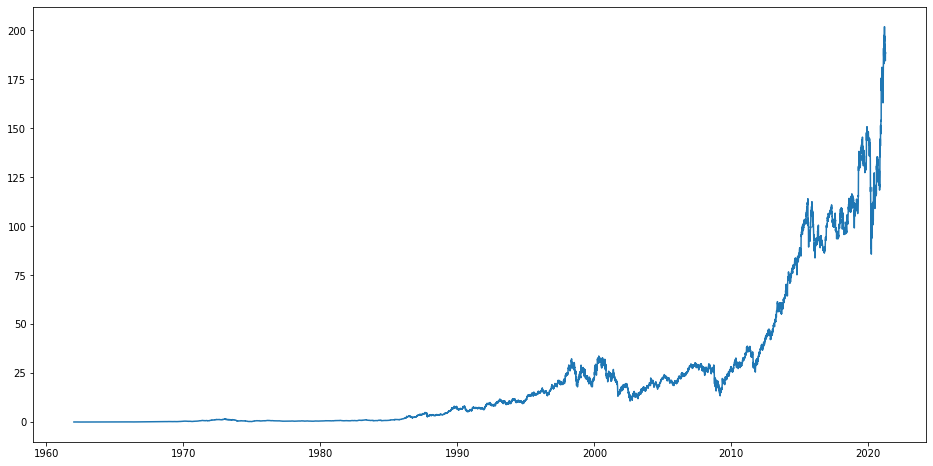

In [7]:
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']
plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')
plt.show() 

In [8]:
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])
for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]


In [9]:
new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)

final_dataset=new_dataset.values

train_data=final_dataset[0:int(training_set),:]
valid_data=final_dataset[int(training_set):,:]

scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)

x_train_data,y_train_data=[],[]

for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])
    
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

In [10]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=3,batch_size=3,verbose=2)

Epoch 1/3
3461/3461 - 159s - loss: 1.7495e-05
Epoch 2/3
3461/3461 - 183s - loss: 6.9949e-06
Epoch 3/3
3461/3461 - 183s - loss: 4.8308e-06


In [11]:
inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

In [12]:
X_test=[]

for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

<ipython-input-13-2c211ec602a2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=predicted_closing_price


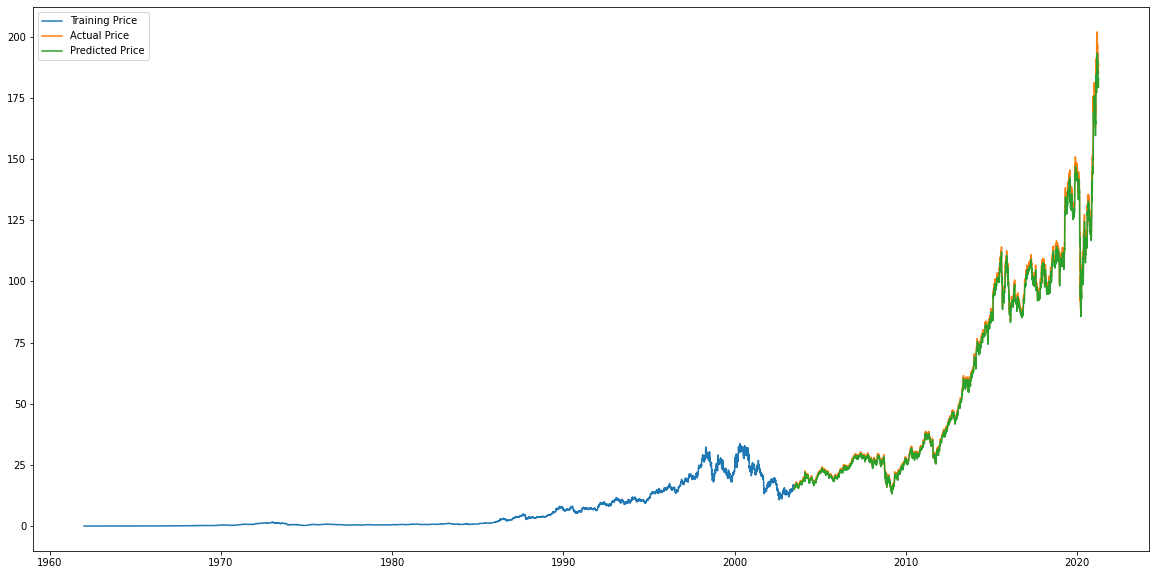

In [13]:
train_data=new_dataset[:int(training_set)]
valid_data=new_dataset[int(training_set):]
valid_data['Predictions']=predicted_closing_price
plt.plot(train_data["Close"], label = 'Training Price')
plt.plot(valid_data["Close"], label = 'Actual Price')
plt.plot(valid_data["Predictions"], label = 'Predicted Price')
plt.legend()
plt.show()

In [17]:
closing_data_df = pd.DataFrame({"TrainData": train_data['Close'], "ActualData": valid_data['Close'], "PredictedData": valid_data['Predictions']})
closing_data_df

,TrainData,ActualData,PredictedData
Date,,,
1962-01-02,0.0583984,NaN,NaN
1962-01-03,0.0591822,NaN,NaN
1962-01-04,0.0591822,NaN,NaN
1962-01-05,0.0593784,NaN,NaN
1962-01-08,0.0591822,NaN,NaN
...,...,...,...
2021-03-29,NaN,184.85,180.202423
2021-03-30,NaN,185.53,179.442871
2021-03-31,NaN,184.52,179.915665


In [24]:
    train = closing_data_df['TrainData'].dropna().values
    train_dates = closing_data_df['TrainData'].dropna().index.values
    actual = closing_data_df['ActualData'].dropna().values
    predict = closing_data_df['PredictedData'].dropna().values

    data = {'train':train, 'actual':actual, 'predict':predict}

    print(data)

{'train': array([0.05839844048023224, 0.059182245284318924, 0.059182245284318924,
       ..., 16.206153869628906, 15.831489562988281, 15.648140907287598],
      dtype=object), 'actual': array([15.233624458312988, 15.464798927307129, 15.416971206665039, ...,
       184.52000427246094, 188.97000122070312, 188.5], dtype=object), 'predict': array([ 15.263543,  14.925146,  14.997503, ..., 179.91566 , 179.29887 ,
       182.8042  ], dtype=float32)}


In [28]:
train_dates

array(['1962-01-02T00:00:00.000000000', '1962-01-03T00:00:00.000000000',
       '1962-01-04T00:00:00.000000000', ...,
       '2003-06-20T00:00:00.000000000', '2003-06-23T00:00:00.000000000',
       '2003-06-24T00:00:00.000000000'], dtype='datetime64[ns]')

In [14]:
print('Model accuracy (%)')
Y_p=scaler.inverse_transform(lstm_model.predict(x_train_data))
Y_t=scaler.inverse_transform(y_train_data.reshape(y_train_data.shape[0],1))
print(round((1-(metrics.mean_absolute_error(Y_t, Y_p)/Y_t.mean()))*100,2))

Model accuracy (%)
93.91
